In [ ]:
%rm -rf /SimCLRv1-keras-tensorflow

!git clone https://github.com/mwdhont/SimCLRv1-keras-tensorflow.git

In [1]:
%ls
%cd SimCLRv1-keras-tensorflow/
!pip install -r requirements.txt

Volume in drive C is Windows
 Volume Serial Number is 66FD-0D67

 Directory of c:\Users\michi\Desktop\SimCLR

22/07/2020  03:19 PM    <DIR>          .
22/07/2020  03:19 PM    <DIR>          ..
22/07/2020  01:08 PM            11,536 0_illustration_SoftmaxCosineSim.ipynb
22/07/2020  03:28 PM             6,848 1_data_processing_trashnet.ipynb
22/07/2020  03:34 PM           257,005 2_model_SimCLR.ipynb
22/07/2020  03:18 PM             6,772 Classifier.py
22/07/2020  01:15 PM    <DIR>          data
22/07/2020  01:36 PM             2,487 DataGeneratorClass.py
22/07/2020  01:27 PM             3,645 DataGeneratorSimCLR.py
22/07/2020  03:19 PM             5,610 evaluate_features.py
22/07/2020  03:19 PM    <DIR>          figures
16/07/2020  10:13 PM    <DIR>          img
14/07/2020  10:31 PM             1,091 LICENSE
22/07/2020  01:20 PM    <DIR>          models
22/07/2020  02:44 PM             3,499 README.md
22/07/2020  01:39 PM               218 requirements.txt
22/07/2020  03:20 PM          

In [21]:
import numpy as np
import pickle
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.applications.vgg16 import VGG16 #https://keras.io/applications/#vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import tensorflow as tf

from evaluate_features import get_features, linear_classifier, tSNE_vis

# Load Dataframe

In [22]:
df = pd.read_pickle("data/df.pickle")
df.head()

,filename,class_label,class_one_hot
0,/mmdetection/notebooks/Trashnet/repo/data/proc...,plastic,"[0, 0, 0, 0, 1]"
1,/mmdetection/notebooks/Trashnet/repo/data/proc...,plastic,"[0, 0, 0, 0, 1]"
2,/mmdetection/notebooks/Trashnet/repo/data/proc...,plastic,"[0, 0, 0, 0, 1]"
3,/mmdetection/notebooks/Trashnet/repo/data/proc...,plastic,"[0, 0, 0, 0, 1]"
4,/mmdetection/notebooks/Trashnet/repo/data/proc...,plastic,"[0, 0, 0, 0, 1]"


In [23]:
class_labels = ["cardboard", "glass", "metal", "paper", "plastic"]
num_classes = len(df['class_one_hot'][0])

print("# of training instances:", len(df.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df.class_label == label).sum()}")

# of training instances: 2390 

# of 'cardboard' training instances: 403
# of 'glass' training instances: 501
# of 'metal' training instances: 410
# of 'paper' training instances: 594
# of 'plastic' training instances: 482


In [24]:
df_train, df_val_test = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)
df_val, df_test = train_test_split(df_val_test, test_size=0.50, random_state=42, shuffle=True)

print("# of training instances:", len(df_train.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_train.class_label == label).sum()}")
    
print()
print("# of validation instances:", len(df_val.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_val.class_label == label).sum()}")

print()
print("# of test instances:", len(df_test.index), "\n")
for label in class_labels:
    print(f"# of '{label}' training instances: {(df_test.class_label == label).sum()}")
    
dfs = {
    "train": df_train,
    "val": df_val,
    "test": df_test
}

# of training instances: 1673 

# of 'cardboard' training instances: 299
# of 'glass' training instances: 358
# of 'metal' training instances: 286
# of 'paper' training instances: 405
# of 'plastic' training instances: 325

# of validation instances: 358 

# of 'cardboard' training instances: 47
# of 'glass' training instances: 84
# of 'metal' training instances: 51
# of 'paper' training instances: 100
# of 'plastic' training instances: 76

# of test instances: 359 

# of 'cardboard' training instances: 57
# of 'glass' training instances: 59
# of 'metal' training instances: 73
# of 'paper' training instances: 89
# of 'plastic' training instances: 81


In [25]:
# Img size
size = 80
height_img = size
width_img = size

input_shape = (height_img, width_img, 3)

# Load pretrained VGG16 & Feature evaluation

In [26]:
params_vgg16 = {'weights': "imagenet", 
                'include_top': False, 
                'input_shape': input_shape, 
                'pooling': None}

# Design model
base_model = VGG16(**params_vgg16)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_130 (InputLayer)       [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [27]:
feat_dim = 2 * 2 * 512

# Build SimCLR-Model

In [28]:
from DataGeneratorSimCLR import DataGeneratorSimCLR as DataGenerator
from SimCLR import SimCLR

### Properties

In [29]:
batch_size = 32
# Projection_head
num_layers_ph = 2
feat_dims_ph = [2048, 128]
num_of_unfrozen_layers = 1 #Note: with 1, all weights of the base_model are still frozen (last layer is max_pool)
save_path = 'models/trashnet'

In [30]:
SimCLR = SimCLR(
        base_model = base_model,
        input_shape = input_shape,
        batch_size = batch_size,
        feat_dim = feat_dim,
        feat_dims_ph = feat_dims_ph,
        num_of_unfrozen_layers = num_of_unfrozen_layers,
        save_path = save_path
    )

In [31]:
params_generator = {'batch_size': batch_size,
                    'shuffle' : True,
                    'width':width_img,
                    'height': height_img,
                    'VGG': True
                   }

# Generators
data_train = DataGenerator(df_train.reset_index(drop=True), **params_generator)
data_val = DataGenerator(df_val.reset_index(drop=True), subset = "val", **params_generator) #val keeps the unity values on the same random places ~42
data_test = DataGenerator(df_test.reset_index(drop=True), subset = "test", **params_generator) #test keeps the unity values on the diagonal

In [15]:
y_predict_test_before = SimCLR.predict(data_test)

# SimCLR - Round 1: Only Projection head

## Training SimCLR

In [32]:
SimCLR.train(data_train, data_val, epochs = 5)

Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 0s - loss: 388.1753 - binary_accuracy: 0.9989
Epoch 00001: val_loss improved from inf to 337.23475, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_25.h5
53/53 [==============================] - 65s 1s/step - loss: 387.2483 - binary_accuracy: 0.9989 - val_loss: 337.2348 - val_binary_accuracy: 0.9987
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 294.6216 - binary_accuracy: 0.9993
Epoch 00002: val_loss improved from 337.23475 to 250.86018, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_25.h5
53/53 [==============================] - 37s 694ms/step - loss: 293.8218 - binary_accuracy: 0.9993 - val_loss: 250.8602 - val_binary_accuracy: 0.9985
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 214.6073 - binary_accuracy: 0.9993
Epoch 00003: val_loss improved from 250.8

In [17]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [18]:
print(f"Random guess accuracy: {round(1/(2*batch_size),4)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

Random guess accuracy: 0.0156
accuracy - test - before: 0.55
accuracy - test - after: 0.92


In [19]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")
print("\n") 
print("y_predict_test_after - Second diagonal")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i + 2 * batch_size][i],2), end=" | ")
print("\n")    

y_predict_test_before
0.62 | 0.64 | 0.75 | 0.55 | 0.33 | 0.73 | 0.15 | 0.81 | 0.53 | 0.25 | 0.17 | 0.64 | 0.51 | 0.88 | 0.62 | 

y_predict_test_after
0.98 | 0.34 | 0.94 | 0.92 | 0.94 | 0.98 | 0.99 | 0.92 | 0.91 | 0.82 | 0.77 | 0.97 | 0.99 | 1.0 | 0.94 | 

y_predict_test_after - Second diagonal
0.99 | 0.87 | 0.76 | 0.89 | 0.2 | 0.99 | 0.96 | 0.98 | 1.0 | 0.26 | 0.92 | 0.74 | 1.0 | 0.86 | 0.97 | 



## Feature Evaluation

Note that this evaluation corresponds with the unaltered pretrained weights

In [33]:
fractions = [1.0, 0.2, 0.05]

### Logistic regression evaluation

In [21]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

280

In [22]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.79 

              precision    recall  f1-score   support

   cardboard       0.87      0.84      0.86        57
       glass       0.64      0.78      0.70        59
       metal       0.83      0.71      0.76        73
       paper       0.80      0.89      0.84        89
     plastic       0.81      0.70      0.75        81

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.78       359
weighted avg       0.79      0.79      0.79       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.7 

              precision    recall  f1-score   support

   cardboard       0.90      0.79      0.84        57
       glass       0.55      0.69      0.61        59
       metal       0.69      0.47      0.56        73
       paper       0.70      0.83      0.76        89
     plastic       0.71      0.69      0.70        81

    accuracy                           

### Fine tuned model

In [23]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [24]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning attempt 1
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 1.41 - Validation Accuracy: 0.74
Learning diverged, stopped.
Learning attempt 2
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 1.43 - Validation Accuracy: 0.71
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 1.06 - Validation Accuracy: 0.72
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | Training Loss at end of cycle: 0.99 - Validation Accuracy: 0.74
Learning diverged, stopped.
Learning attempt 3
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.64 - Validation Accuracy: 0.79
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.45 - Validation Accuracy: 0.83
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | Training Lo

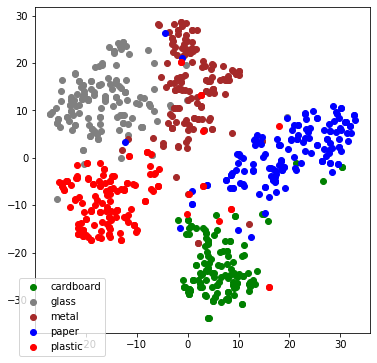

In [43]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 2: Unfreeze last convolutional layer

In [26]:
y_predict_test_before = y_predict_test_after

## Training SimCLR

In [34]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 2, r = 2, lr = 5e-5, epochs = 5)   

trainable parameters: 6.82 M.
non-trainable parameters: 12.35 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 0s - loss: 63.1003 - binary_accuracy: 0.9998
Epoch 00001: val_loss improved from inf to 53.87106, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_29.h5
53/53 [==============================] - 65s 1s/step - loss: 62.9327 - binary_accuracy: 0.9998 - val_loss: 53.8711 - val_binary_accuracy: 0.9998
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 46.4392 - binary_accuracy: 0.9998
Epoch 00002: val_loss improved from 53.87106 to 38.98457, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_29.h5
53/53 [==============================] - 40s 754ms/step - loss: 46.3047 - binary_accuracy: 0.9998 - val_loss: 38.9846 - val_binary_accuracy: 0.9991
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 33.1485 - binary_acc

In [28]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [29]:
print(f"Random guess accuracy: {round(1/(2*batch_size),4)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

Random guess accuracy: 0.0156
accuracy - test - before: 0.92
accuracy - test - after: 0.93


In [30]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")

y_predict_test_before
0.98 | 0.34 | 0.94 | 0.92 | 0.94 | 0.98 | 0.99 | 0.92 | 0.91 | 0.82 | 0.77 | 0.97 | 0.99 | 1.0 | 0.94 | 

y_predict_test_after
0.96 | 0.85 | 0.98 | 0.95 | 0.97 | 0.92 | 0.96 | 0.92 | 0.93 | 0.95 | 0.88 | 0.9 | 0.95 | 0.99 | 0.88 | 

## Feature Evaluation

### Logisitic regression

In [35]:
base_model = SimCLR.base_model
fractions = [1.0, 0.2, 0.05]

In [36]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

481

In [37]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.8 

              precision    recall  f1-score   support

   cardboard       0.86      0.86      0.86        57
       glass       0.71      0.76      0.74        59
       metal       0.78      0.78      0.78        73
       paper       0.84      0.88      0.86        89
     plastic       0.78      0.70      0.74        81

    accuracy                           0.80       359
   macro avg       0.79      0.80      0.80       359
weighted avg       0.80      0.80      0.80       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.71 

              precision    recall  f1-score   support

   cardboard       0.84      0.82      0.83        57
       glass       0.55      0.66      0.60        59
       metal       0.69      0.56      0.62        73
       paper       0.75      0.84      0.79        89
     plastic       0.74      0.67      0.70        81

    accuracy                           

### Fine tuned model

In [38]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                            }
params_training_classifier = {'1.0':{
                                "reg_dense" : 0.005,
                                "reg_out" : 0.005,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 15, 10]
                                },
                              '0.2':{
                                "reg_dense" : 0.075,
                                "reg_out" : 0.01,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 5e-5],
                                "epochs" : [5, 5, 20, 15]
                              },
                              '0.05':{
                                "reg_dense" : 0.01,
                                "reg_out" : 0.02,
                                "nums_of_unfrozen_layers" : [5, 5, 6, 7],
                                "lrs" : [1e-3, 1e-4, 5e-5, 1e-5],
                                "epochs" : [5, 5, 20, 15]
                              }                              
                            }

In [39]:
for fraction in fractions:    
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = params_training_classifier[str(fraction)]["reg_dense"],
                                reg_out = params_training_classifier[str(fraction)]["reg_out"],
                                nums_of_unfrozen_layers = params_training_classifier[str(fraction)]["nums_of_unfrozen_layers"],
                                lrs = params_training_classifier[str(fraction)]["lrs"],
                                epochs = params_training_classifier[str(fraction)]["epochs"],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning attempt 1
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.70- Training Acc: 0.98- Validation Acc: 0.80
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.48- Training Acc: 0.99- Validation Acc: 0.82
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | Training Loss at end of cycle: 0.40- Training Acc: 1.00- Validation Acc: 0.85
CYCLE 3: num_of_unfrozen_layers: 7 - epochs: 10 - lr: 5.0e-05 | Training Loss at end of cycle: 0.37- Training Acc: 1.00- Validation Acc: 0.84
Learning attempt 2
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.67- Training Acc: 0.96- Validation Acc: 0.80
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.44- Training Acc: 1.00- Validation Acc: 0.84
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | T

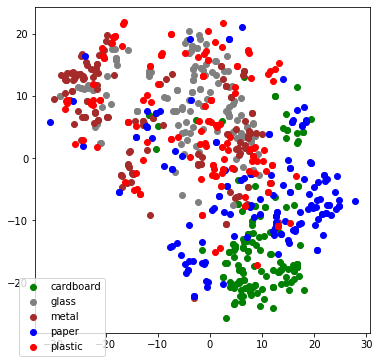

In [40]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 3: Unfreeze 2 last convolutional layer

In [20]:
y_predict_test_before = y_predict_test_after

NameError: name 'y_predict_test_after' is not defined

## Training SimCLR

In [41]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, data_val, num_of_unfrozen_layers = 3, r = 3, lr = 1e-5, epochs = 5)   

trainable parameters: 9.18 M.
non-trainable parameters: 10.0 M.
Train for 53 steps, validate for 12 steps
Epoch 1/5
52/53 [============================>.] - ETA: 1s - loss: 15.1720 - binary_accuracy: 0.9961
Epoch 00001: val_loss improved from inf to 14.29073, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_41.h5
53/53 [==============================] - 69s 1s/step - loss: 15.1566 - binary_accuracy: 0.9962 - val_loss: 14.2907 - val_binary_accuracy: 0.9989
Epoch 2/5
52/53 [============================>.] - ETA: 0s - loss: 14.0014 - binary_accuracy: 0.9995
Epoch 00002: val_loss improved from 14.29073 to 13.59118, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_41.h5
53/53 [==============================] - 43s 809ms/step - loss: 13.9954 - binary_accuracy: 0.9995 - val_loss: 13.5912 - val_binary_accuracy: 0.9986
Epoch 3/5
52/53 [============================>.] - ETA: 0s - loss: 13.4155 - binary_accu

In [42]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [ ]:
print(f"Random guess accuracy: {round(1/(2*batch_size),2)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

In [ ]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")

## Feature Evaluation

In [43]:
base_model = SimCLR.base_model

In [44]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

825

In [45]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.83 

              precision    recall  f1-score   support

   cardboard       0.88      0.81      0.84        57
       glass       0.83      0.85      0.84        59
       metal       0.82      0.85      0.83        73
       paper       0.79      0.87      0.82        89
     plastic       0.85      0.77      0.81        81

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.8 

              precision    recall  f1-score   support

   cardboard       0.87      0.79      0.83        57
       glass       0.77      0.78      0.77        59
       metal       0.81      0.77      0.79        73
       paper       0.78      0.87      0.82        89
     plastic       0.78      0.77      0.77        81

    accuracy                           

### Fine tuned model

In [46]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                        }

In [47]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = 0.005,
                                reg_out = 0.003,
                                nums_of_unfrozen_layers = [5, 5, 6, 7],
                                lrs = [1e-3, 1e-4, 5e-5, 1e-5],
                                epochs = [5, 5, 15, 10],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning attempt 1
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.45- Training Acc: 1.00- Validation Acc: 0.80
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.28- Training Acc: 1.00- Validation Acc: 0.81
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | Training Loss at end of cycle: 0.27- Training Acc: 1.00- Validation Acc: 0.85
CYCLE 3: num_of_unfrozen_layers: 7 - epochs: 10 - lr: 1.0e-05 | Training Loss at end of cycle: 0.25- Training Acc: 1.00- Validation Acc: 0.84
Learning attempt 2
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.43- Training Acc: 0.99- Validation Acc: 0.81
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.30- Training Acc: 1.00- Validation Acc: 0.84
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | T

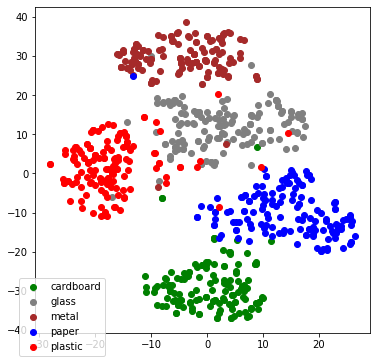

In [48]:
tSNE_vis(df_train, features_train, class_labels)

# SimCLR - Round 4: Unfreeze 3 last convolutional layer

In [49]:
y_predict_test_before = y_predict_test_after

## Training SimCLR

In [50]:
#Unfreeze
SimCLR.unfreeze_and_train(data_train, 
                          data_val, 
                          num_of_unfrozen_layers = 4, 
                          r = 4, 
                          lr = 1e-5, 
                          epochs = 10)  

trainable parameters: 11.54 M.
non-trainable parameters: 7.64 M.
Train for 53 steps, validate for 12 steps
Epoch 1/10
52/53 [============================>.] - ETA: 1s - loss: 13.0095 - binary_accuracy: 0.9982
Epoch 00001: val_loss improved from inf to 12.37576, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_53.h5
53/53 [==============================] - 73s 1s/step - loss: 12.9989 - binary_accuracy: 0.9982 - val_loss: 12.3758 - val_binary_accuracy: 0.9993
Epoch 2/10
52/53 [============================>.] - ETA: 0s - loss: 12.1288 - binary_accuracy: 0.9997
Epoch 00002: val_loss improved from 12.37576 to 11.86861, saving model to //mmdetection/notebooks/Trashnet/repo/models/trashnet/SimCLR/SimCLR_07_22_09h_53.h5
53/53 [==============================] - 47s 896ms/step - loss: 12.1243 - binary_accuracy: 0.9998 - val_loss: 11.8686 - val_binary_accuracy: 0.9998
Epoch 3/10
52/53 [============================>.] - ETA: 0s - loss: 11.7486 - binary_

In [ ]:
y_predict_test_after = SimCLR.predict(data_test)

## SimCLR-output check

In [ ]:
print(f"Random guess accuracy: {round(1/(2*batch_size),2)}")

print(f"accuracy - test - before: {np.round(np.sum(data_test[0][1] * y_predict_test_before[:batch_size])/(2*batch_size),2)}")
print(f"accuracy - test - after: {np.round(np.sum(data_test[0][1] * y_predict_test_after[:batch_size])/(2*batch_size),2)}")

In [ ]:
print("y_predict_test_before")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_before[i][i],2), end=" | ")
print("\n")    
print("y_predict_test_after")
for i in range(min(batch_size, 15)):
    print(np.round(y_predict_test_after[i][i],2), end=" | ")

## Feature Evaluation

### Logistic Regression

In [51]:
base_model = SimCLR.base_model

In [52]:
features_train, y_train, feats = get_features(base_model, df_train, class_labels)
features_test, y_test, feats = get_features(base_model, df_test, class_labels)
np.count_nonzero(features_train[0])

473

In [53]:
# Training logistic regression classifier on 3 fractions of the data
# Optimal regularization is determined from a 5-fold cross-validation
fractions = [1.0, 0.2, 0.05]
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    linear_classifier(features_train, y_train, features_test, y_test, class_labels, fraction = fraction)

    ==== 100.0% of the training data used ==== 

Accuracy on test: 0.82 

              precision    recall  f1-score   support

   cardboard       0.88      0.81      0.84        57
       glass       0.81      0.86      0.84        59
       metal       0.82      0.81      0.81        73
       paper       0.81      0.87      0.84        89
     plastic       0.79      0.75      0.77        81

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359

    ==== 20.0% of the training data used ==== 

Accuracy on test: 0.78 

              precision    recall  f1-score   support

   cardboard       0.78      0.79      0.78        57
       glass       0.76      0.88      0.82        59
       metal       0.81      0.70      0.75        73
       paper       0.77      0.83      0.80        89
     plastic       0.80      0.73      0.76        81

    accuracy                          

### Fine tuned model

In [54]:
batch_size_classifier = 32
params_generator_classifier = {'max_width':width_img,
                            'max_height': height_img,
                            'num_classes': num_classes,
                            'VGG': True
                        }

In [55]:
for fraction in fractions:
    print(f"    ==== {fraction * 100}% of the training data used ==== \n")
    SimCLR.train_NL_and_evaluate(dfs = dfs,
                                batch_size = batch_size_classifier,
                                params_generator = params_generator_classifier,
                                fraction = fraction,
                                class_labels = class_labels,
                                reg_dense = 0.005,
                                reg_out = 0.003,
                                nums_of_unfrozen_layers = [5, 5, 6, 7],
                                lrs = [1e-3, 1e-4, 5e-5, 1e-5],
                                epochs = [5, 5, 15, 10],
                                verbose_epoch = 0,
                                verbose_cycle = 0
                                )

    ==== 100.0% of the training data used ==== 

Learning attempt 1
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.45- Training Acc: 0.98- Validation Acc: 0.77
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.30- Training Acc: 1.00- Validation Acc: 0.83
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | Training Loss at end of cycle: 0.32- Training Acc: 1.00- Validation Acc: 0.83
CYCLE 3: num_of_unfrozen_layers: 7 - epochs: 10 - lr: 1.0e-05 | Training Loss at end of cycle: 0.26- Training Acc: 1.00- Validation Acc: 0.83
Learning attempt 2
CYCLE 0: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-03 | Training Loss at end of cycle: 0.51- Training Acc: 0.99- Validation Acc: 0.83
CYCLE 1: num_of_unfrozen_layers: 5 - epochs: 5 - lr: 1.0e-04 | Training Loss at end of cycle: 0.34- Training Acc: 1.00- Validation Acc: 0.84
CYCLE 2: num_of_unfrozen_layers: 6 - epochs: 15 - lr: 5.0e-05 | T

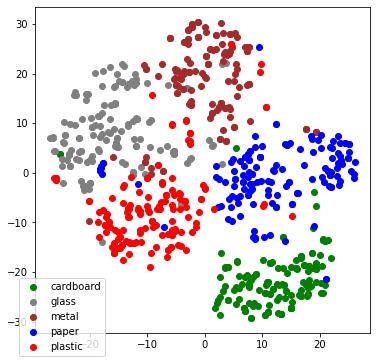

In [56]:
tSNE_vis(df_train, features_train, class_labels)